# Imports

In [2]:
import os
import ast
import numpy as np
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from datetime import date

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as sklearn_rbf_kernel

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

seed = 42

np_qml.random.seed(seed)

# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)

# Circuit

In [47]:
n_quibits = 4
dev = qml.device("lightning.gpu", wires=n_quibits)

def default_embedding(x, wires):
    qml.AngleEmbedding(features=x, wires=wires, rotation='Y')

    qml.RX(x[0], wires=wires[0])
    qml.RZ(x[1], wires=wires[1])


# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    # Replicar dados: x[0] em qubits 0 e 2; x[1] em qubits 1 e 3
    for i in [0, 2]:
        qml.RX(x[0] * 2 * np.pi, wires=wires[i])
        qml.RY(np.pi / 4, wires=wires[i])
        qml.RZ(np.pi / 4, wires=wires[i])
    for i in [1, 3]:
        qml.RX(x[1] * 2 * np.pi, wires=wires[i])
        qml.RY(np.pi / 4, wires=wires[i])
        qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_entanglement):
    for i in range(len(W) // 2):

        qml.Rot(W[2*i][0], W[2*i][1], W[2*i][2], wires=0)
        qml.Rot(W[2*i+1][0], W[2*i+1][1], W[2*i+1][2], wires=1)
        if i % 2 == 0:
            qml.CNOT(wires=[0, 1])
        else:
            qml.CNOT(wires=[1, 0]) if n_entanglement > 1 else qml.CNOT(wires=[0, 1])

def circuit(weights, X, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        default_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))

    for W in weights:
        entanglement(W, n_entanglement)

    return qml.expval(qml.PauliZ(wires=0))

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type1(weights, X, embedding_type = 'AE'):
    return circuit(weights, X, 1, embedding_type)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type2(weights, X, embedding_type = 'AE'):
    return circuit(weights, X, 2, embedding_type)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type3(weights, X, embedding_type = 'AE'):
    return circuit(weights, X, 3, embedding_type)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type4(weights, X, embedding_type = 'AE'):
    return circuit(weights, X, 4, embedding_type)

@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def circuit_type5(weights, X, embedding_type = 'AE'):
    return circuit(weights, X, 5, embedding_type)

def qvc_classifier(qnode, w, b, X, embedding_type):
    return qnode(w, X, embedding_type) + b

# Show clusters

In [36]:
def print_decision_region(X, qnode, embedding_type, x_max, y_max, weights, bias, complement = ''):
    cm = 'viridis'

    # Plot decision region
    predictions = np.array([qvc_classifier(qnode, weights, bias, xi, embedding_type) for xi in X])

    continuous_preds = 2 / (1 + np_qml.exp(-predictions)) - 1

    rotulos_preditos = np.array(continuous_preds > np.mean(continuous_preds))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 3D do embedding
    ax1 = fig.add_subplot(121, projection='3d')
    sc = ax1.scatter(X[:,0], X[:,1], continuous_preds, 
                    c=rotulos_preditos, cmap=cm, s=50)
    
    # =============================================
    # Adicionar plano z=0
    # =============================================
    # Criar uma grade para o plano
    x_range = np.linspace(X[:,0].min(), X[:,0].max(), 50)
    y_range = np.linspace(X[:,1].min(), X[:,1].max(), 50)
    X_grid, Y_grid = np.meshgrid(x_range, y_range)
    Z_grid = np.zeros_like(X_grid)  # Plano em z=0

    # Plotar o plano
    ax1.plot_surface(X_grid, Y_grid, Z_grid, 
                    color='gray', alpha=0.3, edgecolor='none')
    # =============================================
    ax1.set_title(f"Embedding Quântico 3D {complement}")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    ax1.set_zlabel("Expectativa Z")
    ax1.view_init(elev=10, azim=50)

    # Plot do resultado do clustering
    ax2 = fig.add_subplot(122)

    # Make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = np.array([np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())])
    
    # Generate predictions for grid
    predictions_grid = np.array([qvc_classifier(qnode, weights, bias, xi, embedding_type) for xi in X_grid])
    predictions_grid = 2 / (1 + np_qml.exp(-predictions_grid)) - 1
    Z = np.reshape(predictions_grid, xx.shape)

    # Plot decision regions
    cnt = ax2.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), 
                      cmap=cm, alpha=0.8, extend="both")
    
    ax2.set_title(f"Decision Region ({complement})")
    ax2.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    # Add colorbar to the second subplot
    fig.colorbar(cnt, ax=ax2, ticks=[-1, 1])

    # Plot data points with predictions
    ax2.scatter(X[:, 0], X[:, 1], c=rotulos_preditos, cmap=cm, 
               marker="o", edgecolors="k")

    # Calculate and display metrics
    if len(np.unique(rotulos_preditos)) > 1:
        silhouette = silhouette_score(X, rotulos_preditos)
        davies = davies_bouldin_score(X, rotulos_preditos)
        calinski = calinski_harabasz_score(X, rotulos_preditos)
        
        metric_text = (
            f"Silhouette: {silhouette:.2f}\n"
            f"Davies-Bouldin: {davies:.2f}\n"
            f"Calinski-Harabasz: {calinski:.2f}"
        )
        
        fig.text(0.95, 0.95, metric_text,
                 transform=fig.gca().transAxes,
                 ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8, 
                          edgecolor='gray', boxstyle='round'))
    else:
        fig.text(0.95, 0.95, "Metrics require\nmultiple clusters",
                 transform=plt.gca().transAxes,
                 ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8,
                          edgecolor='gray', boxstyle='round'))


    plt.tight_layout()
    plt.show()
    # plt.title(f"Decision Region ({complement})")
    # plt.show()

# Show cost evolution

In [34]:
# Função para plotar a evolução
def plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history):
    plt.figure(figsize=(12, 6))
    
    epochs = range(1, len(intra_loss_history)+1)
    
    plt.plot(epochs, total_loss_history, 'k--', label='Total Loss', alpha=0.8)
    plt.plot(epochs, intra_loss_history, 'b', label='Intra Loss (Variância)')
    plt.plot(epochs, inter_loss_history, 'r', label='Inter Loss (Separação)')
    # plt.plot(epochs, entropy_loss_history, 'g', label='Entropy Loss')
    # plt.plot(epochs, reg_loss_history, 'g', label='Reg Loss (L2)')
    
    plt.title('Evolução das Componentes da Função de Custo')
    plt.xlabel('Época')
    plt.ylabel('Valor da Loss')
    # plt.yscale('log')  # Usar escala logarítmica se as perdas variarem muito
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.show()

# Cost

In [35]:
# Inicializa listas para armazenar as perdas
intra_loss_history = []
inter_loss_history = []
# entropy_loss_history = []
total_loss_history = []

# Transformação não linear via kernel RBF
def rbf_kernel(x1, x2):
    return np_qml.exp(-1 * np_qml.linalg.norm(x1 - x2)**2)


def cost_function(weights, bias, qnode, features, embedding_type):
    #Saídas do circuito quântico e predições contínuas:
    raw_outputs = np_qml.array([qvc_classifier(qnode, weights, bias, x, embedding_type) for x in features])
    continuous_preds = 2 / (1 + np_qml.exp(-raw_outputs)) - 1

    # Máscaras para separar clusters:
    mask_0 = continuous_preds < np.mean(continuous_preds)
    mask_1 = continuous_preds >= np.mean(continuous_preds)
    
    # Médias dos clusters (com verificação de vazios):
    mean_0 = np_qml.mean(features[mask_0], axis=0) if np_qml.any(mask_0) else np_qml.zeros(features.shape[1])
    mean_1 = np_qml.mean(features[mask_1], axis=0) if np_qml.any(mask_1) else np_qml.zeros(features.shape[1])

    # Similaridades via kernel RBF:
    similarities_0 = np_qml.array([rbf_kernel(x, mean_0) for x in features])
    similarities_1 = np_qml.array([rbf_kernel(x, mean_1) for x in features])

    # Centróides ponderados:
    weights_0 = np_qml.where(mask_0, similarities_0, 0)
    weights_1 = np_qml.where(mask_1, similarities_1, 0)

    centroid_0 = np_qml.sum(continuous_preds * weights_0) / (np_qml.sum(weights_0) + 1e-8)
    centroid_1 = np_qml.sum(continuous_preds * weights_1) / (np_qml.sum(weights_1) + 1e-8)

    # Perdas Intra-Cluster e Inter-Cluster:
    intra_loss = (
        np_qml.sum(weights_0 * (continuous_preds - centroid_0)**2)/(np_qml.sum(weights_0) + 1e-8) +
        np_qml.sum(weights_1 * (continuous_preds - centroid_1)**2)/(np_qml.sum(weights_1) + 1e-8)
    ) / 2

    inter_loss = -np_qml.abs(np_qml.tanh(centroid_1) - np_qml.tanh(centroid_0))
    
    total_loss = intra_loss + 0.5 * inter_loss  
    
    intra_loss_history.append(0.7 * intra_loss.item() )
    inter_loss_history.append(0.3 * inter_loss.item())
    # entropy_loss_history.append( 0.2 * entropy_loss.item())
    total_loss_history.append(total_loss.item())

    return total_loss

In [41]:
# Inicializa listas para armazenar as perdas
intra_loss_history = []
inter_loss_history = []
total_loss_history = []

def parzen_density_estimate(X, sigma):
    """Estimativa de densidade Parzen (Gaussiana) para todos os pontos."""
    N, d = X.shape
    K = np.exp(-np.sum((X[:, np.newaxis] - X) ** 2, axis=2) / (2 * sigma ** 2))
    density = K.sum(axis=1) / (N * (2 * np.pi * sigma ** 2) ** (d/2))
    return density

def laplacian_pdf_distance(features, mask_0, mask_1, sigma):
    """Calcula a Laplacian PDF Distance entre dois clusters."""
    # Estimativa de densidade global
    D = parzen_density_estimate(features, sigma)
    D_inv_sqrt = np.diag(1 / np.sqrt(D + 1e-8))  # Evitar divisão por zero
    
    # Matriz de afinidade (Gaussiana)
    pairwise_dists = np.sum((features[:, np.newaxis] - features) ** 2, axis=2)
    K = np.exp(-pairwise_dists / (2 * sigma ** 2))
    
    # Matriz Laplaciana K_f
    K_f = D_inv_sqrt @ K @ D_inv_sqrt
    
    # Índices dos clusters
    cluster_0 = np.where(mask_0)[0]
    cluster_1 = np.where(mask_1)[0]
    
    # Termos intra-cluster (similaridade dentro dos clusters)
    intra_0 = K_f[cluster_0][:, cluster_0].sum()
    intra_1 = K_f[cluster_1][:, cluster_1].sum()
    
    # Termo inter-cluster (similaridade entre clusters)
    inter = K_f[cluster_0][:, cluster_1].sum()
    
    # Cálculo de L (coseno do ângulo entre médias)
    L = inter / np.sqrt(intra_0 * intra_1 + 1e-8)
    DL = -np.log(L + 1e-8)  # Evitar log(0)
    
    return DL, intra_0 + intra_1, inter

def cost_function(weights, bias, qnode, features, embedding_type, sigma=0.1):
    # Passo 1: Obter predições contínuas (exemplo simplificado)
    raw_outputs = np.array([qvc_classifier(qnode, weights, bias, x, embedding_type) for x in features])
    continuous_preds = 2 / (1 + np.exp(-raw_outputs)) - 1
    
    # Passo 2: Máscaras para separar clusters
    threshold = np.mean(continuous_preds)
    mask_0 = continuous_preds < threshold
    mask_1 = continuous_preds >= threshold
    
    # Passo 3: Calcular Laplacian PDF Distance
    total_loss, intra_loss, inter_loss = laplacian_pdf_distance(features, mask_0, mask_1, sigma)
    
    # Registro das perdas (normalização opcional)
    intra_loss_history.append(intra_loss)
    inter_loss_history.append(-inter_loss)  # Minimizar similaridade inter-cluster
    total_loss_history.append(total_loss)
    
    return total_loss

# Train Function

In [37]:
def train(
    qnode, 
    features, 
    n_params, 
    n_qubits, 
    n_layers, 
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    seed,
    embedding_type, 
    iterations=100, 
    batch_size=32,
    show_log=False
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np_qml.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
    bias_init = np_qml.array(0.0, requires_grad=True)

    weights = weights_init
    bias = bias_init

    print_decision_region(features, qnode, embedding_type, x_max=np.pi, y_max=np.pi, 
                           weights=weights, bias=bias, 
                        #    complement=f"{qnode.__name__} {n_layers} {optimizer.__name__}"
                        complement="Before Training"
                           )

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 30
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        # print(current_batch_size)
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]

        wrapped_cost_function = lambda weights, bias: cost_function(weights, bias, qnode, X_train_batch, embedding_type)

        # Train model on batch
        params = [weights, bias]
        (weights, bias), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_cost'] = iteration_cost
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        logger.info(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # Early stopping if no improvement
        if no_improvement >= patience:
            break

    # Validation metrics
    predictions_val = np.array([qvc_classifier(qnode, training_info['best_weights'], training_info['best_bias'], xi, embedding_type) for xi in X_val])
    # predictions_val = np.sign(predictions_val)
    continuous_preds = 2 / (1 + np_qml.exp(-predictions_val)) - 1
    
    if len(np.unique(continuous_preds > np.mean(continuous_preds))) > 1:
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, continuous_preds > np.mean(continuous_preds))
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, continuous_preds > np.mean(continuous_preds))
        training_info['silhouette'] = silhouette_score(X_val, continuous_preds > np.mean(continuous_preds))

    print_decision_region(features, qnode, embedding_type, x_max=np.pi, y_max=np.pi, 
                           weights=training_info['best_weights'], bias=training_info['best_bias'], 
                        #    complement=f"{qnode.__name__} {n_layers} {optimizer.__name__}"
                        complement="After Training"
                           )

    logger.info(f'Custo Final: {training_info["best_cost"]}')
    logger.info(f'Silhouette: {training_info["silhouette"]}')
    logger.info(f'Davies Bouldin: {training_info["davies_bouldin"]}')
    logger.info(f'Calinski Harabasz: {training_info["calinski_harabasz"]}')

    return (training_info["best_cost"], 
            training_info["best_weights"], 
            training_info["best_bias"], 
            training_info["silhouette"], 
            training_info["davies_bouldin"], 
            training_info["calinski_harabasz"])

# Normalize data

In [8]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

# Calculate Composite Score

In [9]:
def calculate_composite_score(
    cost, 
    silhouette, 
    davies_bouldin, 
    calinski_harabasz,
    min_cost, max_cost,
    min_silhouette, max_silhouette,
    min_davies, max_davies,
    min_calinski, max_calinski
):
    # Normalização min-max com tratamento para divisão por zero
    def normalize(value, min_val, max_val, reverse=False):
        if max_val == min_val:
            return 0.5  # Valor neutro se todos forem iguais
        if reverse:
            return (max_val - value) / (max_val - min_val)  # Quanto menor, melhor
        else:
            return (value - min_val) / (max_val - min_val)  # Quanto maior, melhor

    # Aplicar normalização
    norm_cost = normalize(cost, min_cost, max_cost, reverse=True)
    norm_silhouette = normalize(silhouette, min_silhouette, max_silhouette) if silhouette is not None else 0
    norm_davies = normalize(davies_bouldin, min_davies, max_davies, reverse=True) if davies_bouldin is not None else 0
    norm_calinski = normalize(calinski_harabasz, min_calinski, max_calinski) if calinski_harabasz is not None else 0

    # Calcular pontuação composta (ajuste os pesos)
    composite_score = (
        0.3 * norm_cost +
        0.3 * norm_silhouette +
        0.2 * norm_davies +
        0.2 * norm_calinski
    )
    return composite_score

# Execution Function

In [10]:
def execute(
        X, 
        result_archive_name,
        iterations=100,
        batch_size=32,
        show_log=False,
        embedding_type='AE'
    ):
    # Definindo as combinações de otimizadores e circuitos a serem testados
    optimizers = {
        'SPSAOptimizer': SPSAOptimizer,
        'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
        'GradientDescentOptimizer': GradientDescentOptimizer,
        'AdamOptimizer': AdamOptimizer
    }

    circuits = [
        (circuit_type1, 2),
        # (circuit_type2, 4),
        (circuit_type3, 6), 
    #     (circuit_type4, 6), 
        (circuit_type5, 8)
    ]

    # Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
    optimizer_params = {
        'NesterovMomentumOptimizer': {'stepsize': 0.01, 'momentum': 0.9},
        'GradientDescentOptimizer': {'stepsize': 0.01},
        'SPSAOptimizer': {'maxiter': 10, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101},
        'AdamOptimizer': {'stepsize': 0.01}
    }

    # Parâmetros do experimento
    num_layers_options = [
        2, 
        4
    ]  # Escolher o número de camadas para o experimento

    log_results = []

    # Loop para experimentar combinações
    for circuit_fn, n_quibits in circuits:
        # Draw the circuit graphically
        for n_layers in num_layers_options:
            for optimizer_name, optimizer_class in optimizers.items():
                try:
                    logger.info(f"Testando: {circuit_fn.__name__} - {optimizer_name} - {n_layers} camadas")

                    # Instanciar o circuito e o QNode
                    circuit = circuit_fn
                    qnode = qml.QNode(circuit, dev, interface="torch")

                    cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
                        qnode,
                        X,
                        n_params=3,
                        n_qubits=n_quibits,
                        n_layers=n_layers,
                        weight_init_max=np.pi,
                        optimizer=optimizer_class,
                        dic_optimizer=optimizer_params[optimizer_name],
                        seed=seed,
                        embedding_type=embedding_type,
                        iterations=iterations,
                        batch_size=batch_size,
                        show_log=show_log
                    )

                    # Adicionar os resultados ao log
                    log_results.append({
                        'circuit_fn': circuit_fn.__name__,
                        'optimizer': optimizer_name,
                        'num_layers': n_layers,
                        'score_davies': score_davies,
                        'score_calinski': score_calinski,
                        'score_silhouette': score_silhouette,
                        'cost': cost,
                        'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                        'bias': bias, # Convertendo para lista, caso seja um array
                        'qnode': qnode
                    })

                except Exception as e:
                    logger.error(f"Erro ao testar {circuit_fn.__name__} - {optimizer_name} - {n_layers} camadas: {e}")
                    raise

    # Aplicar min-max scaling para normalizar as métricas
    all_costs = [f["cost"] for f in log_results]
    all_silhouettes = [f["score_silhouette"] for f in log_results if f["score_silhouette"] is not None]
    all_davies = [f["score_davies"] for f in log_results if f["score_davies"] is not None]
    all_calinski = [f["score_calinski"] for f in log_results if f["score_calinski"] is not None]

    min_cost, max_cost = min(all_costs), max(all_costs)
    min_sil, max_sil = min(all_silhouettes or [0]), max(all_silhouettes or [0])
    min_davies, max_davies = min(all_davies or [0]), max(all_davies or [0])
    min_cal, max_cal = min(all_calinski or [0]), max(all_calinski or [0])

    # Calcula a pontuação composta para cada fold
    for combination in log_results:
        combination["composite_score"] = calculate_composite_score(
            combination["cost"],
            combination["score_silhouette"],
            combination["score_davies"],
            combination["score_calinski"],
            min_cost, max_cost,
            min_sil, max_sil,
            min_davies, max_davies,
            min_cal, max_cal
        )

    # Seleciona o melhor fold com base na pontuação composta
    best_combination = max(log_results, key=lambda d: d["composite_score"])

    # Exibir os melhores parâmetros e resultados
    logger.info("\nMelhores Resultados:")
    logger.info(f"Otimizador: {best_combination['optimizer']}")
    logger.info(f"Tipo de Circuito: {best_combination['circuit_fn']}")
    logger.info(f"Número de Camadas: {best_combination['num_layers']}")
    logger.info(f"Custo: {best_combination['cost']}")
    logger.info(f"Score Davies: {best_combination['score_davies']}")
    logger.info(f"Score Calinski: {best_combination['score_calinski']}")
    logger.info(f"Score Silhouette: {best_combination['score_silhouette']}")

    # Salvar o log em um arquivo CSV
    log_df = pd.DataFrame(log_results)
    log_df.to_csv(f'{result_archive_name}.csv', index=False)

    logger.info(best_combination['weights'])

    # Visualizar a decisão do melhor modelo
    predictions = np.array(
        [
            qvc_classifier(
                best_combination['qnode'],
                best_combination['weights'], 
                best_combination['bias'], 
                xi,
                embedding_type
            ) for xi in X
        ]
    )

    predictions = np.sign(predictions)
    
    print_decision_region(
        X, 
        best_combination['qnode'],
        embedding_type,
        x_max=np.pi, 
        y_max=np.pi, 
        weights=np_qml.array(best_combination['weights']), 
        bias=best_combination['bias'], 
        predictions=predictions,
        complement='Melhor Resultado'
    )

# 2 Moons

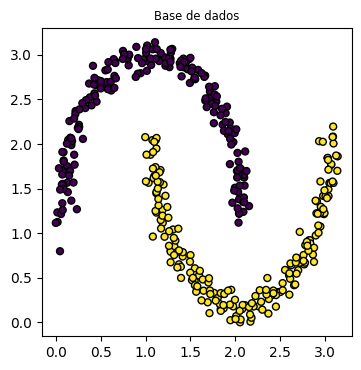

In [12]:
X, y = make_moons(n_samples=400, noise=0.05, random_state=seed)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

## Execution

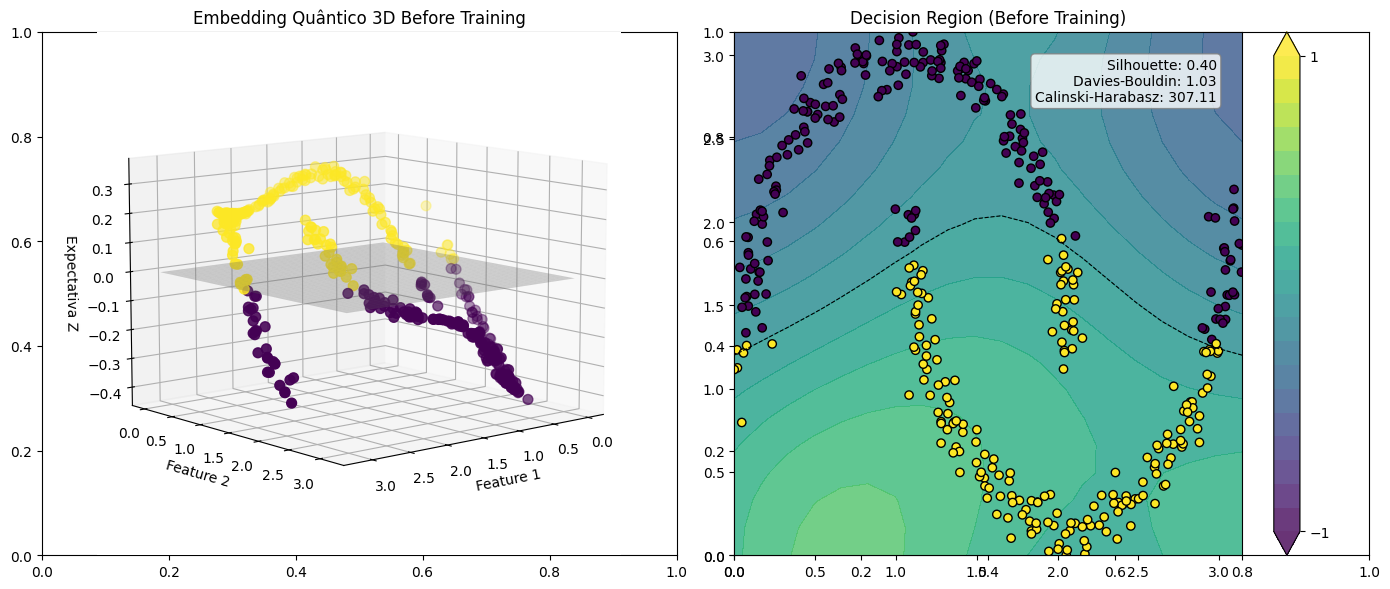

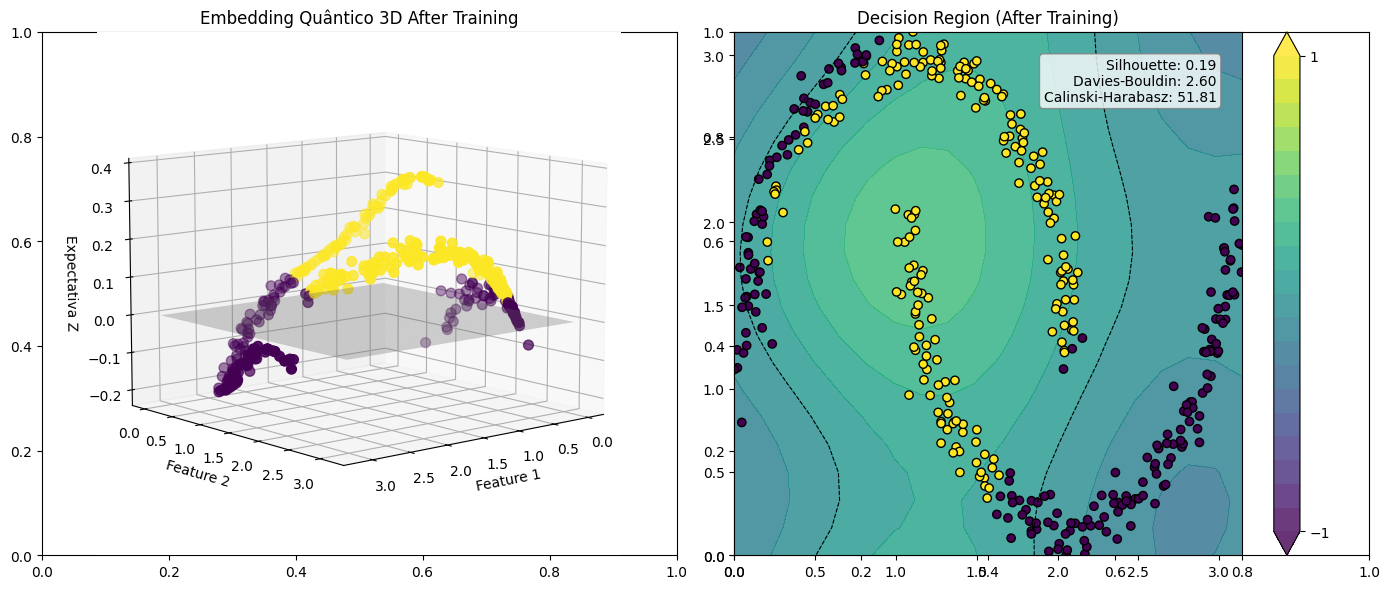

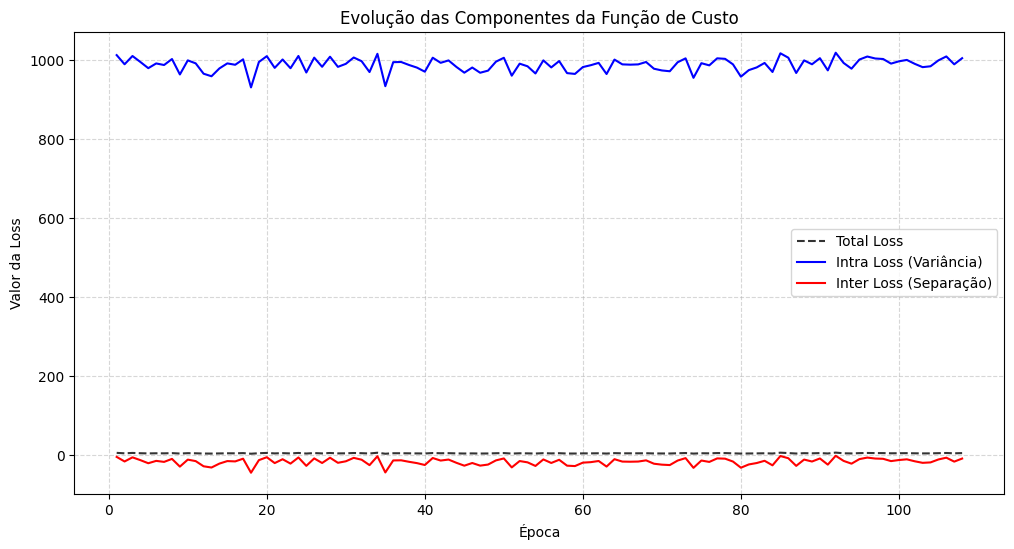

In [48]:
n_qubits = 4
n_params = 3
n_layers = 8
qnode = qml.QNode(circuit_type5, dev)

intra_loss_history = []
inter_loss_history = []
# entropy_loss_history = []
total_loss_history = []

cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 1000},
    seed=seed,
    embedding_type='AE',
    iterations=100,
    batch_size=128,
    show_log=True
)

plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history)

# Blobs

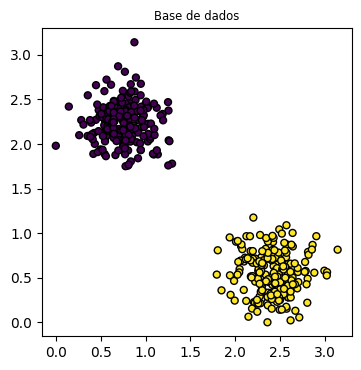

In [74]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

## Execution

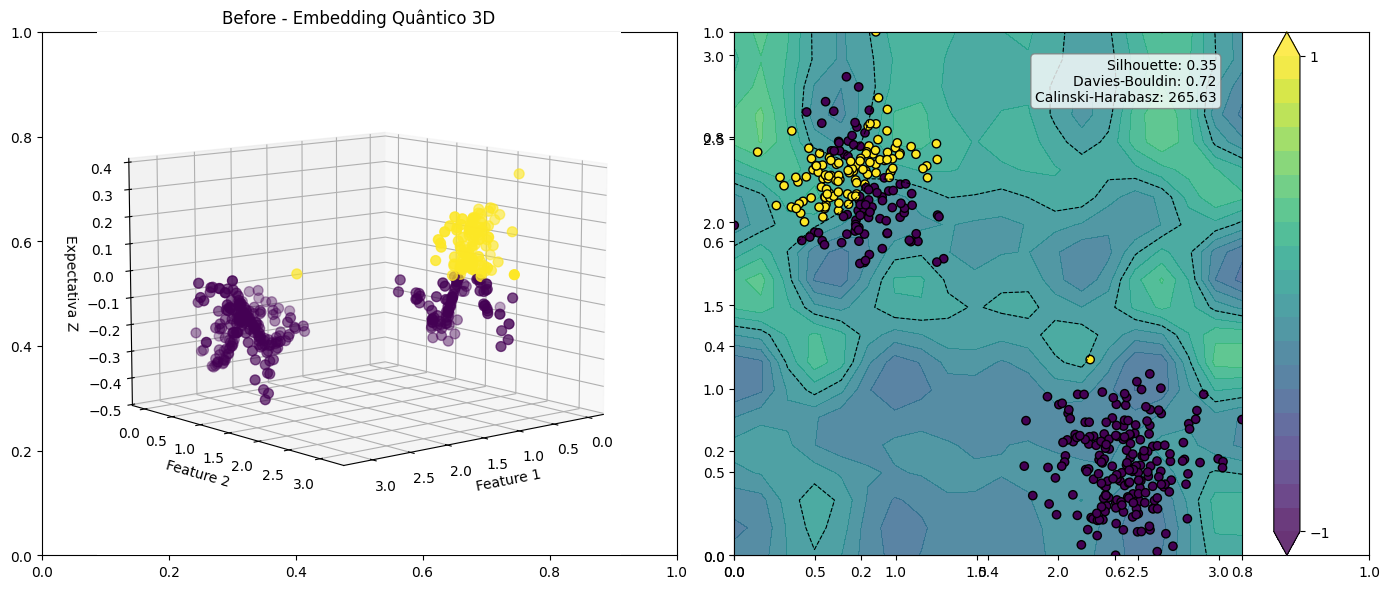

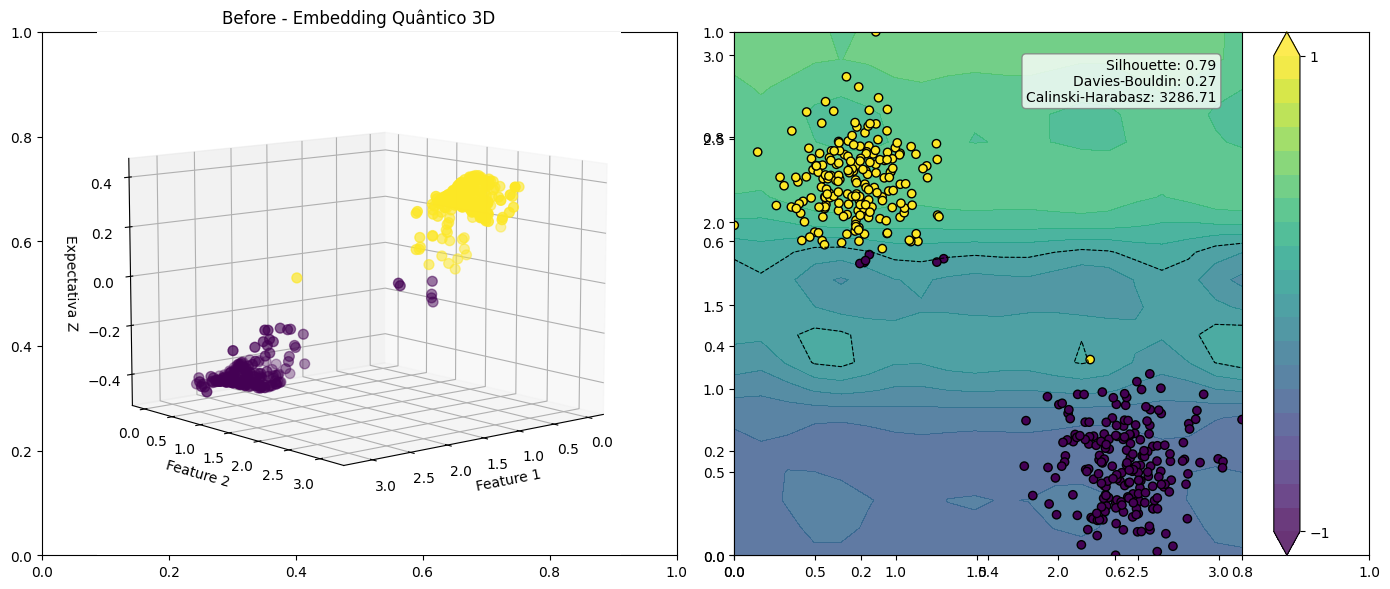

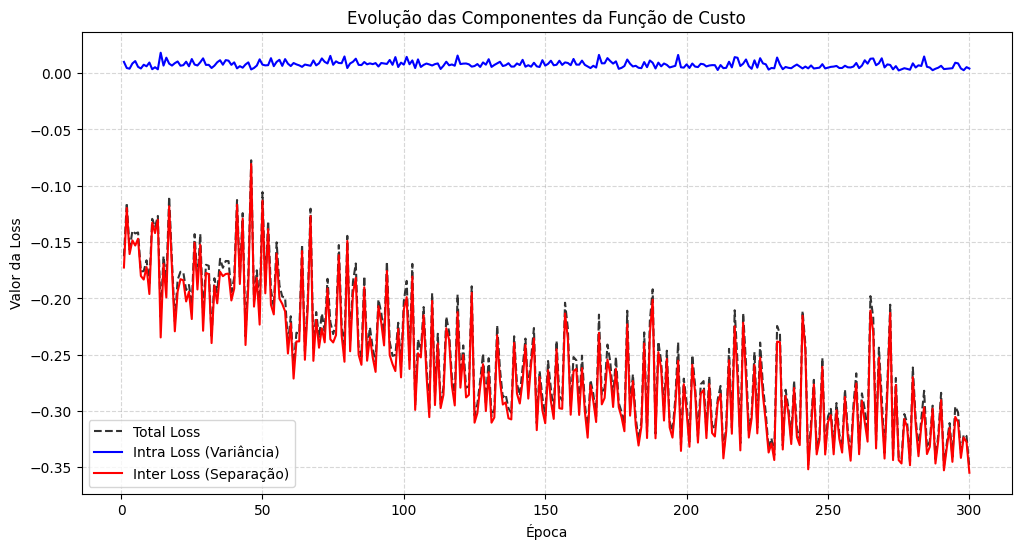

In [75]:
n_qubits = 4
n_params = 3
n_layers = 4
qnode = qml.QNode(circuit_type1, dev)

intra_loss_history = []
inter_loss_history = []
total_loss_history = []

cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 1000},
    seed=seed,
    embedding_type='AE',
    iterations=100,
    batch_size=64,
    show_log=True
)

plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history)

# Circles

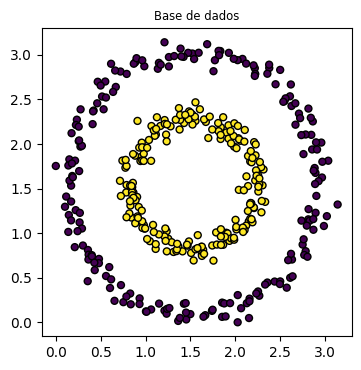

In [76]:
X, y = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

## Execution

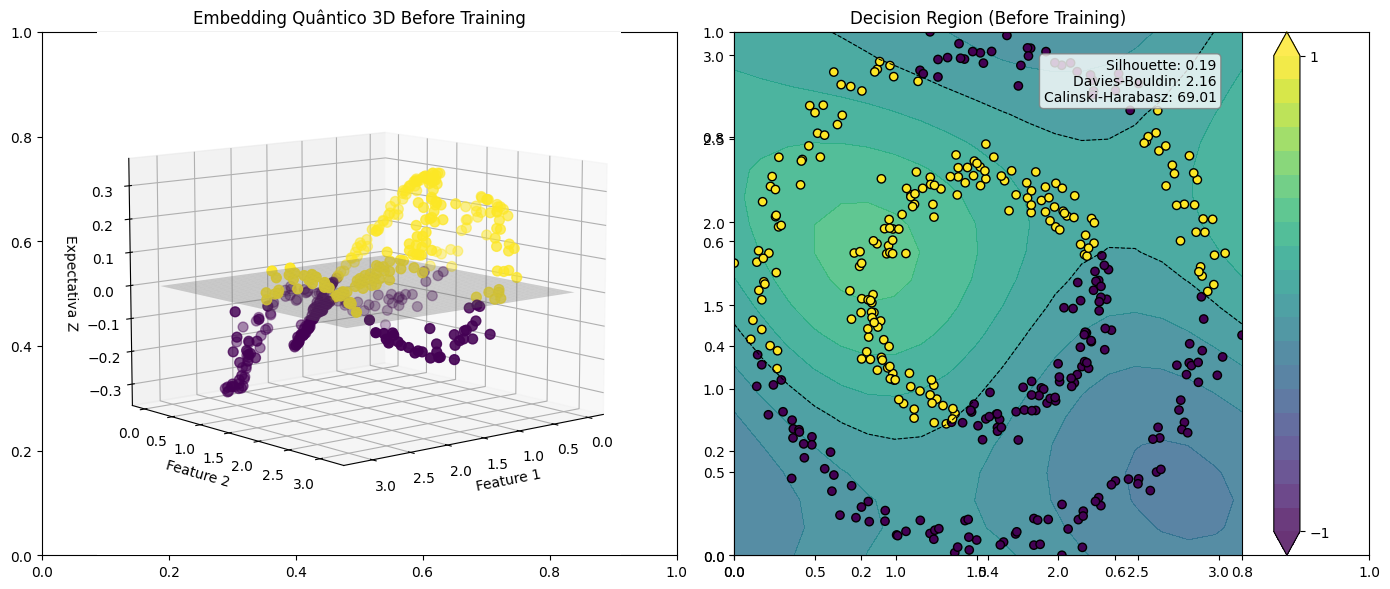

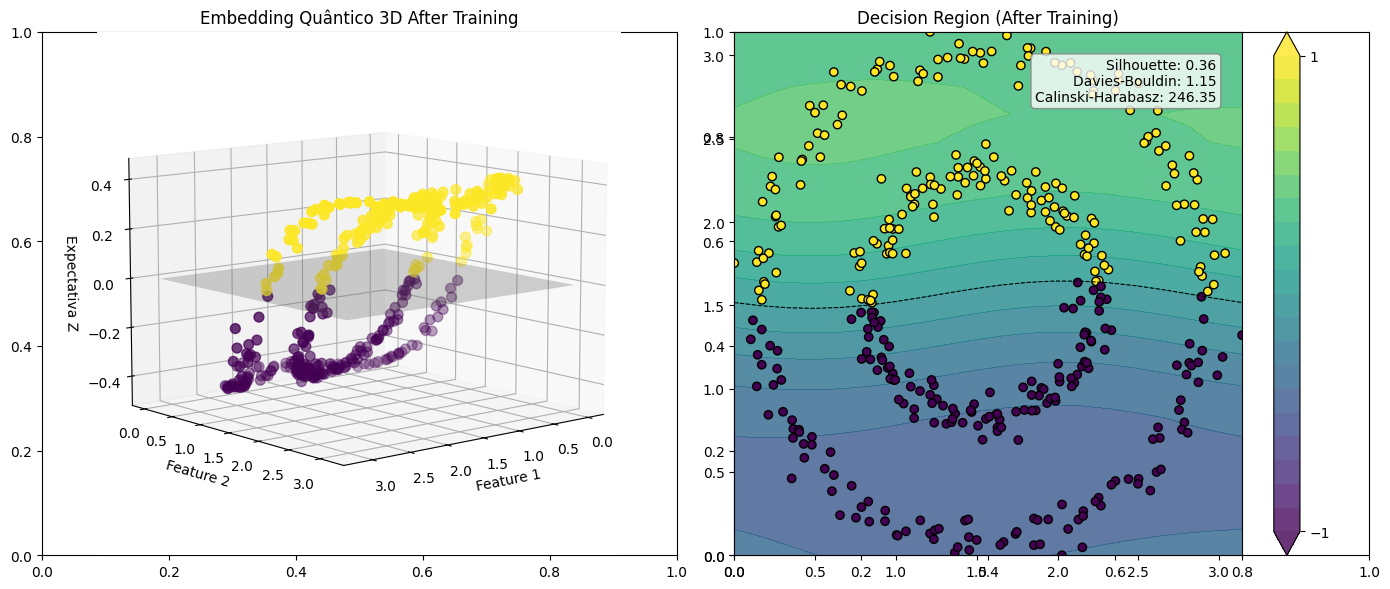

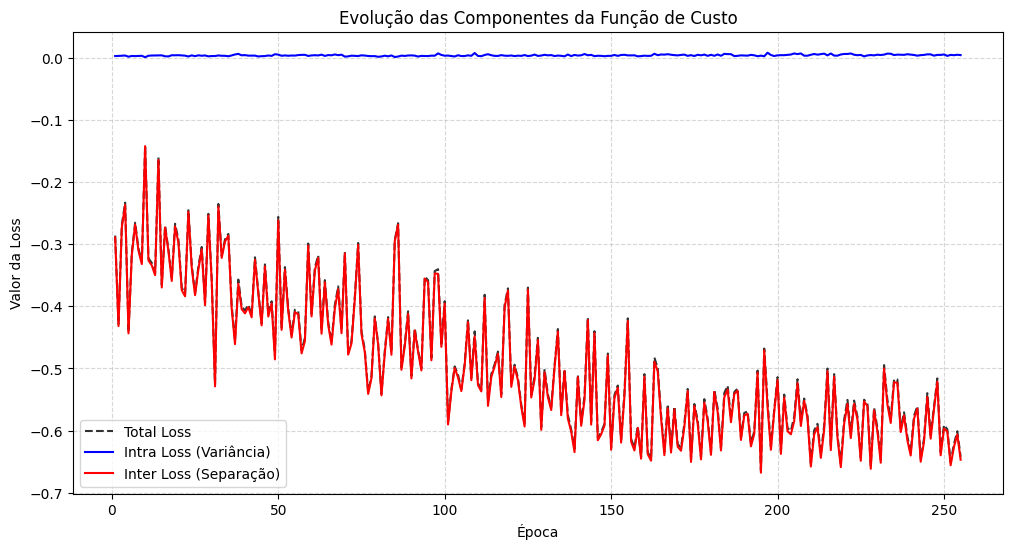

In [107]:
n_qubits = 4
n_params = 3
n_layers = 4
qnode = qml.QNode(circuit_type1, dev)

intra_loss_history = []
inter_loss_history = []
total_loss_history = []

cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 1000},
    seed=seed,
    embedding_type='AE',
    iterations=100,
    batch_size=64,
    show_log=True
)

plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history)